# Prepare Datasets with Lhotse

> Extract features for datasets

In [151]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
#| export
import torch.nn as nn
import torch

from lhotse.dataset import BucketingSampler, OnTheFlyFeatures
from lhotse.dataset.collation import TokenCollater
from lhotse.recipes import download_librispeech, prepare_librispeech, download_ljspeech, prepare_ljspeech
from lhotse.dataset.vis import plot_batch
from lhotse import CutSet, RecordingSet, SupervisionSet, Fbank, FbankConfig, MonoCut, NumpyFilesWriter

import numpy as np
from tempfile import TemporaryDirectory

In [153]:
download_ljspeech('/data/en/LJSpeech')

Path('/data/en/LJSpeech/LJSpeech-1.1')

In [154]:
ljspeech = prepare_ljspeech('/data/en/LJSpeech/LJSpeech-1.1', '../recipes/tts/ljspeech/data')
print(ljspeech)

{'recordings': RecordingSet(len=13100), 'supervisions': SupervisionSet(len=13100)}


## recordings and supervision sets from file

In [155]:
# recording & supervision set
recordings = CutSet.from_file('../recipes/tts/ljspeech/data/ljspeech_recordings_all.jsonl.gz')
supervisions = CutSet.from_file('../recipes/tts/ljspeech/data/ljspeech_supervisions_all.jsonl.gz')

In [156]:
cut_set = CutSet.from_manifests(recordings=recordings, supervisions=supervisions)
print(cut_set[0])
print(len(cut_set))

MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=None, recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)
13100


In [157]:
cut_set = CutSet.from_manifests(
                recordings=ljspeech["recordings"],
                supervisions=ljspeech["supervisions"],
            )
# same as
cut_set = CutSet.from_manifests(**ljspeech)


In [158]:
mini = cut_set.subset(first=3)
for k, v in mini.data.items():
    print(f"key:{k}, value: {v}")

key:LJ001-0001-0, value: MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=None, recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)
key:LJ001-0002-1, value: MonoCut(id='LJ001-0002-1', start=0, duration=1.899546485260771, channel=0, supervisions=[SupervisionSegment(id='LJ001-0002', recording_id='LJ001-0002', start=0.0, duration=1.899546485260771, channel=0, text='in being comparativel

In [159]:
rec0 = recordings[0]
print(rec0)

Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None)


In [160]:
cuts = CutSet.from_manifests(**ljspeech)
cuts_trimmed = cuts.trim_to_supervisions()
mini_cut = cuts.subset(first=3)
mini_cut.to_file('../data/en/LJSpeech-1.1/first_3.jsonl.gz')
print(mini_cut)

CutSet(len=3) [underlying data type: <class 'dict'>]


## feature extraction

In [161]:
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

: 

: 

In [ ]:
conf = FbankConfig(sampling_rate=22050, frame_shift=0.02)
with torch.no_grad():
    cuts = mini_cut.compute_and_store_features(
        extractor=Fbank(conf),
        storage_path='../recipes/tts/ljspeech/data/feats',
        num_jobs=100
    )
cuts.to_file("../recipes/tts/ljspeech/data/ljspeech_fbank_1000.jsonl.gz")

Extracting and storing features (chunks progress):   0%|          | 0/100 [00:00<?, ?it/s]

## Supervision segment + Features + Recording

MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=Features(type='kaldi-fbank', num_frames=483, num_features=80, frame_shift=0.02, sampling_rate=22050, start=0, duration=9.65501134, storage_type='lilcom_chunky', storage_path='../recipes/tts/ljspeech/data/feats/feats-0.lca', storage_key='0,44166', recording_id='None', channels=0), recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)


<matplotlib.image.AxesImage>

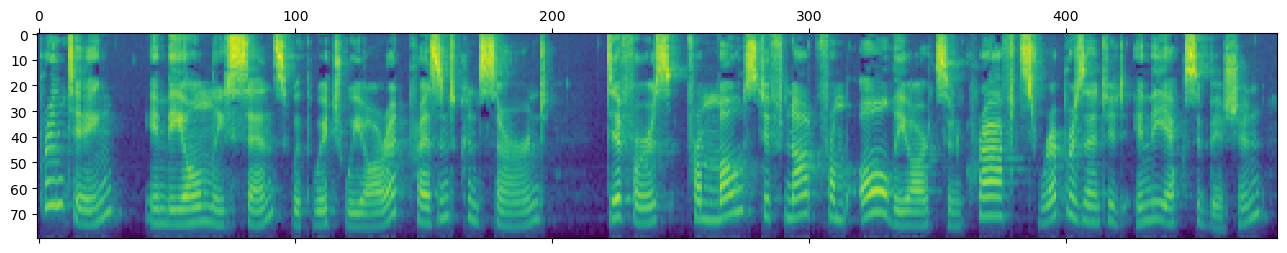

In [ ]:
feats = CutSet.from_file("../recipes/tts/ljspeech/data/ljspeech_fbank_1000.jsonl.gz")
print(feats[0])
feats[0].plot_features()

In [ ]:
# mvn_stats = cuts.compute_global_feature_stats('../recipes/tts/ljspeech/data/feats/mvn_stats.lca', max_cuts=100)

In [ ]:
# feats[0].supervisions[0].custom["tokens"] = "tutu"

TypeError: 'NoneType' object does not support item assignment

In [ ]:
feats[0]

MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=Features(type='kaldi-fbank', num_frames=483, num_features=80, frame_shift=0.02, sampling_rate=22050, start=0, duration=9.65501134, storage_type='lilcom_chunky', storage_path='../recipes/tts/ljspeech/data/feats/feats-0.lca', storage_key='0,44166', recording_id='None', channels=0), recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)

In [ ]:
with CutSet.open_writer('../recipes/tts/ljspeech/data/ljspeech_fbank_1000_ali.jsonl.gz', overwrite=False) as writer:
    for cut in feats:
        for idx, subcut in enumerate(cut.supervisions):
            subcut.alignment = {"word": 0}
            subcut.custom = {"phoneme": 'bloo'}
            print(subcut)
        writer.write(cut, flush=True)


SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom={'phoneme': 'bloo'}, alignment={'word': 0})
SupervisionSegment(id='LJ001-0002', recording_id='LJ001-0002', start=0.0, duration=1.899546485260771, channel=0, text='in being comparatively modern.', language='English', speaker=None, gender='female', custom={'phoneme': 'bloo'}, alignment={'word': 0})
SupervisionSegment(id='LJ001-0003', recording_id='LJ001-0003', start=0.0, duration=9.666621315192744, channel=0, text='For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process', language='English', speaker=None, gender='female', custom={'phoneme': 'bloo'}, alignment={'word

In [ ]:
# feats = CutSet.from_file("../recipes/tts/ljspeech/data/ljspeech_fbank_1000_ali.jsonl.gz")
# print(feats[0])

In [ ]:
from tqdm.notebook import tqdm
cuts[0]
for c in tqdm(cuts):
    text = c.supervisions[0].text
    new_text = text.replace("”", '"').replace("“", '"').upper()
    # c.supervisions[0].tokens = "tutu"
    # text = text.replace("”", '"').replace("“", '"')
    # phonemes = tokenize_text(text_tokenizer, text=text)
    print(c)

  0%|          | 0/3 [00:00<?, ?it/s]

MonoCut(id='LJ001-0001-0', start=0, duration=9.65501133786848, channel=0, supervisions=[SupervisionSegment(id='LJ001-0001', recording_id='LJ001-0001', start=0.0, duration=9.65501133786848, channel=0, text='Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition', language='English', speaker=None, gender='female', custom=None, alignment=None)], features=Features(type='kaldi-fbank', num_frames=483, num_features=80, frame_shift=0.02, sampling_rate=22050, start=0, duration=9.65501134, storage_type='lilcom_chunky', storage_path='../recipes/tts/ljspeech/data/feats/feats-0.lca', storage_key='0,44166', recording_id='None', channels=0), recording=Recording(id='LJ001-0001', sources=[AudioSource(type='file', channels=[0], source='/data/en/LJSpeech/LJSpeech-1.1/wavs/LJ001-0001.wav')], sampling_rate=22050, num_samples=212893, duration=9.65501133786848, channel_ids=[0], transforms=None), custom=None)
Mono

In [ ]:
cut1 = MonoCut("c1", start=0, duration=4.9, channel=0, recording="tutu.wav")
ali1 = np.random.randint(500, size=(121,))
with TemporaryDirectory() as d, NumpyFilesWriter(d) as writer:
    cut1.label_alignment = writer.store_array("c1", ali1, frame_shift=0.04, temporal_dim=0)
    cut1.toto = writer.store_array("c1", ali1, frame_shift=0.04, temporal_dim=0)

print(cut1)

MonoCut(id='c1', start=0, duration=4.9, channel=0, supervisions=[], features=None, recording='tutu.wav', custom={'label_alignment': TemporalArray(array=Array(storage_type='numpy_files', storage_path='/tmp/tmpp25xq2zp', storage_key='c1/c1.npy', shape=[121]), temporal_dim=0, frame_shift=0.04, start=0), 'toto': TemporalArray(array=Array(storage_type='numpy_files', storage_path='/tmp/tmpp25xq2zp', storage_key='c1/c1.npy', shape=[121]), temporal_dim=0, frame_shift=0.04, start=0)})


In [ ]:
#| hide
# import nbdev; nbdev.nbdev_export()